**Real Estate Price Prediction**

**Geekbrains Python for Data Science course competition**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Разбиение на train и test](#split)
* [6. Отбор признаков](#feature_selection)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [11]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Переведу Id, DistrictId в строковый тип, потому что Id уникален для каждого наблюдения и для анализа бессмысленный, DistrictId не является вещественным

In [13]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype(np.int8)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(np.int8)

## 1. EDA  <a class='anchor' id='eda'>

**Целевая переменная**

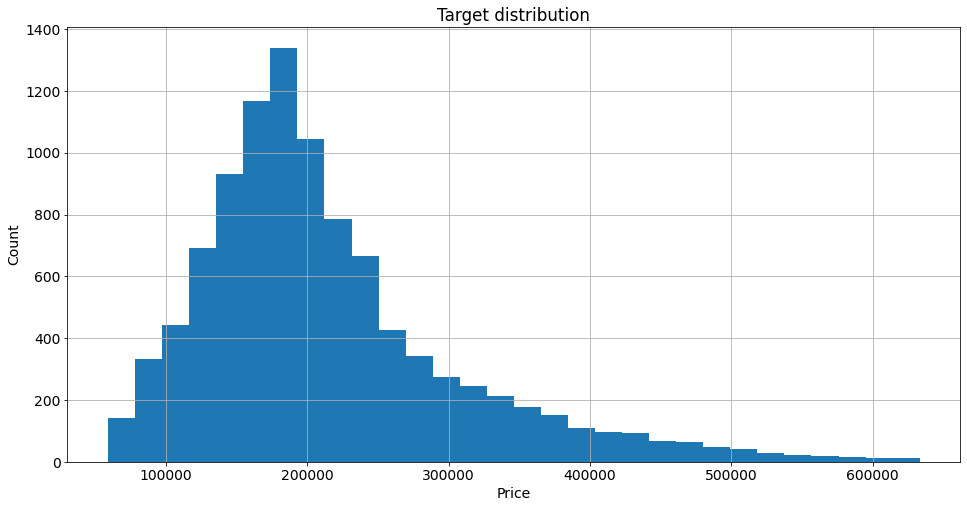

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Распределение целевой переменной выглядит правдоподобным

**Количественные переменные**

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
df_num_features = train_df.select_dtypes(include=['int64','int8','float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

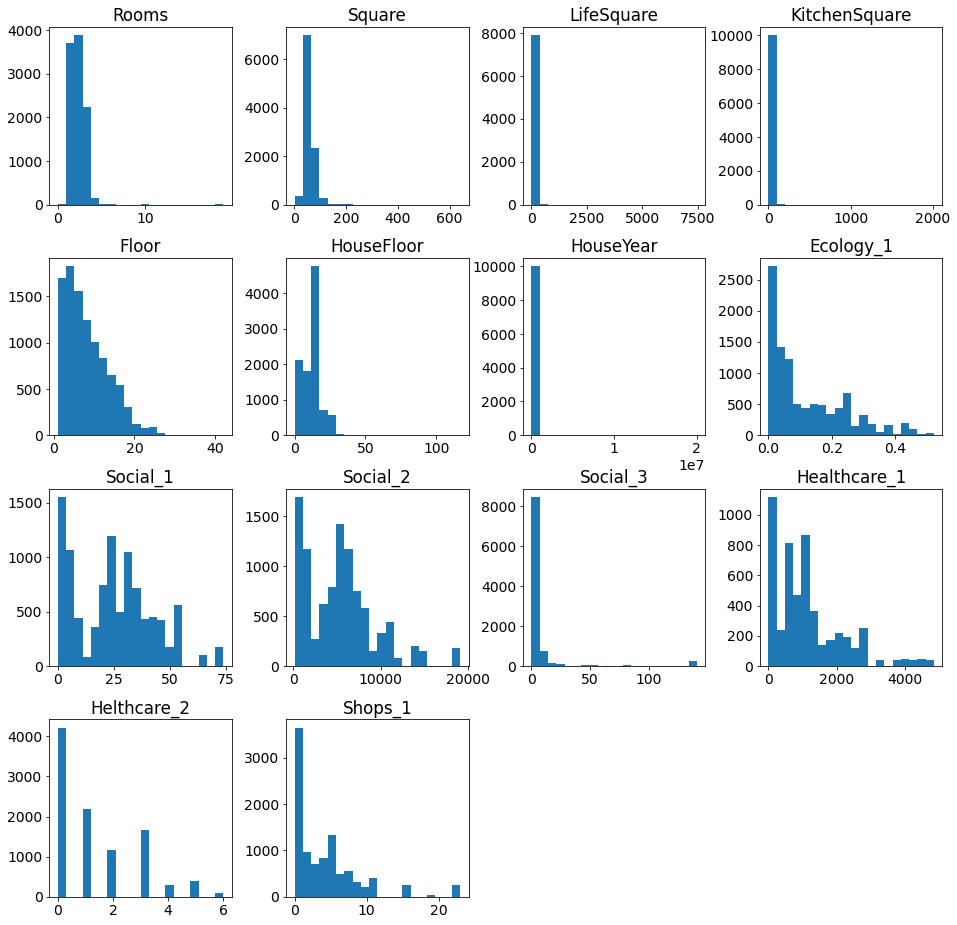

In [17]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

У многих количественных переменных наблюдаются выбросы и необычное распределение

**Номинативные переменные**

In [18]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [19]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
117      1
209      1
207      1
199      1
205      1
Name: DistrictId, Length: 205, dtype: int64

In [20]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [22]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>

Сначала отброшу нижнюю границу Square

In [23]:
train_df.loc[train_df['Square'] < 15, 'Square'] = 15

**Rooms**

In [24]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [25]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10,59.056975,36.223072,10.0,22,22,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
2194,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.110646,1
2728,14865,9,10,60.871266,38.420681,10.0,3,2,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1
3780,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976788,1
5894,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,1
6088,8491,1,19,42.006046,21.779288,7.0,17,17,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1
6401,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.918007,1
7644,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.260887,1
7929,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,1
8794,14003,99,6,59.414334,38.702244,6.0,7,9,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1


In [26]:
train_df.loc[train_df['Rooms_outlier'] == 1, 'Rooms'] = round(train_df['Square']/26, 0).astype(np.int8)

In [27]:
train_df['Rooms'].value_counts()

2    3886
1    3707
3    2237
4     150
5      19
8       1
Name: Rooms, dtype: int64

**Square**

In [28]:
train_df.loc[train_df['Square'] < train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
33,847,74,2,73.314975,74.131261,1.0,7,6,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,254005.381863,0
64,3992,1,3,87.200625,87.730225,0.0,21,22,1977,0.007122,...,B,1,264,0,NaN,0,1,B,300180.365669,0
77,11771,45,1,38.467276,39.624493,1.0,11,9,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,247440.530601,0
100,13343,74,2,79.937665,82.931595,1.0,8,21,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,226808.747168,0
111,13875,20,1,28.438794,32.514021,6.0,6,10,2014,0.019509,...,B,37,7687,11,176.0,5,5,B,199248.114376,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3,96.056784,98.152802,1.0,15,1,2017,0.041125,...,B,46,9515,5,NaN,1,10,B,524365.550705,0
9962,14175,14,1,42.029175,44.682167,10.0,4,4,2018,0.238617,...,B,26,3889,6,705.0,3,6,B,87556.385617,0
9979,2201,6,1,40.043234,41.984322,1.0,3,17,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,134888.083598,0
9987,11665,1,2,62.690057,64.602939,10.0,19,22,2018,0.007122,...,B,1,264,0,NaN,0,1,B,203908.192698,0


В **482** наблюдениях общая площадь меньше жилой площади.
Поменяю их местами

In [29]:
train_df['Square_More_Life_Outlier'] = 0
train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'Square_More_Life_Outlier'] = 1
train_df['Square'], train_df['LifeSquare'] = \
                np.where(train_df['Square'] < train_df['LifeSquare'],\
                (train_df['LifeSquare'],train_df['Square']), (train_df['Square'],train_df['LifeSquare']))

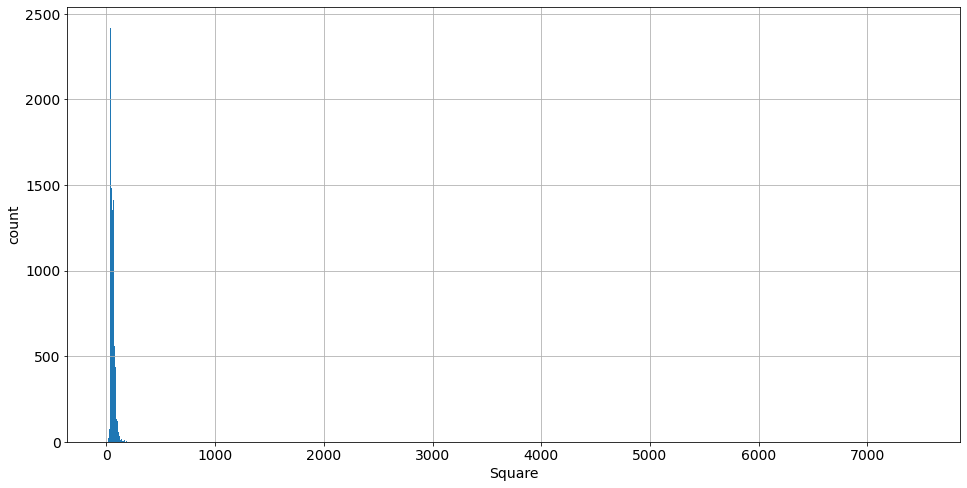

In [30]:
plt.figure(figsize = (16, 8))

train_df['Square'].hist(density=False, bins=1000)
plt.ylabel('count')
plt.xlabel('Square')
plt.show()

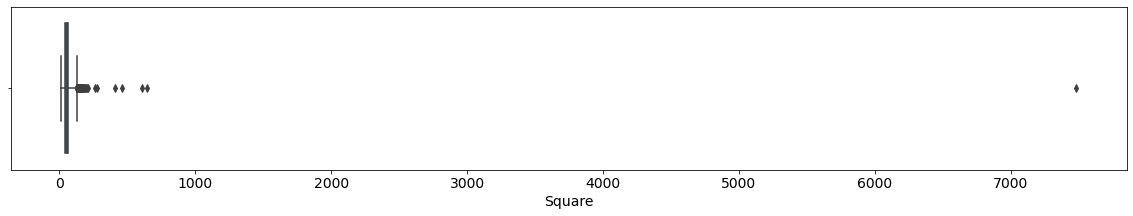

In [31]:
plt.figure(figsize=(20, 3))

sns.boxplot(train_df['Square'], whis=2.5)

plt.xlabel('Square')
plt.show()

In [32]:
train_df['Square'].describe()

count    10000.000000
mean        57.233002
std         77.303562
min         15.000000
25%         41.866858
50%         52.633651
75%         66.004634
max       7480.592129
Name: Square, dtype: float64

***Заменю все значения меньше квантиля .025  и выше .975 на сами квантили***

In [33]:
def q025(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

In [34]:
rooms_quantile025 = train_df.groupby(['Rooms'])['Square'].agg(q025).to_dict()
rooms_quantile975 = train_df.groupby(['Rooms'])['Square'].agg(q975).to_dict()

In [35]:
train_df.loc[train_df['Square'] < train_df['Rooms'].map(rooms_quantile025), 'Square'] = train_df['Rooms'].map(rooms_quantile025)
train_df.loc[train_df['Square'] > train_df['Rooms'].map(rooms_quantile975), 'Square'] = train_df['Rooms'].map(rooms_quantile975) 

In [36]:
train_df['Square'].describe()

count    10000.000000
mean        55.987029
std         18.016849
min         30.060392
25%         41.881659
50%         52.915088
75%         65.825776
max        241.123488
Name: Square, dtype: float64

***LifeSquare***

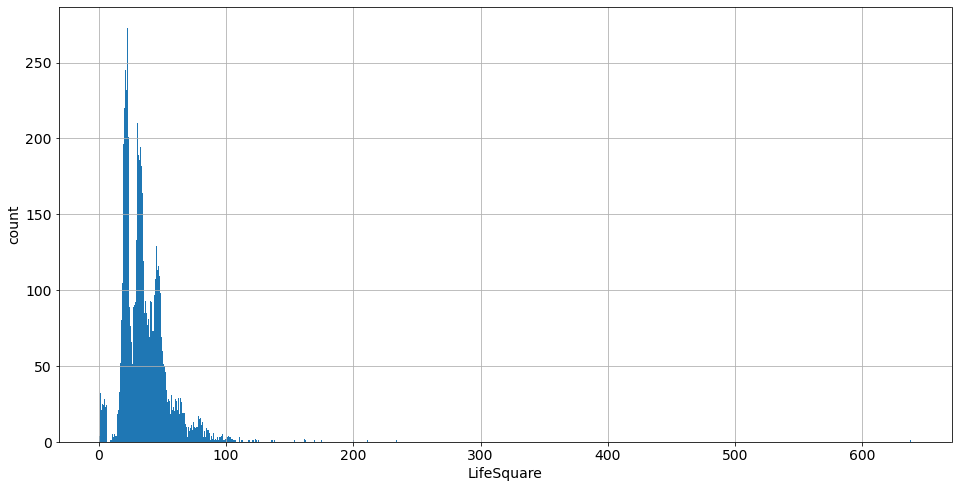

In [37]:
plt.figure(figsize = (16, 8))

train_df['LifeSquare'].hist(density=False, bins=1000)
plt.ylabel('count')
plt.xlabel('LifeSquare')
plt.show()

В основном средний коридорный коэффициент 20%. Оставим еще минимум 10% на кухню. Следовательно, все LifeSquare > 70% от Square приравняем к 70%, а меньше 50% прираняем к 50%

In [38]:
train_df['LifeSquare_outlier'] = 0
condition_min = (train_df['LifeSquare'] > train_df['Square'] * 0.7)

condition_max = (train_df['LifeSquare'] < train_df['Square'] * 0.5)

train_df.loc[condition_min, 'LifeSquare_outlier'] = 1
train_df.loc[condition_max, 'LifeSquare_outlier'] = 1

train_df.loc[condition_min, 'LifeSquare'] = train_df['Square'] * 0.5
train_df.loc[condition_max, 'LifeSquare'] = train_df['Square'] * 0.7

**KitchenSquare** 

In [39]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [40]:
train_df.loc[train_df['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_More_Life_Outlier,LifeSquare_outlier
3,2352,1,1,40.409907,NaN,1.0,10,22,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,0
8,9951,1,1,46.887892,23.443946,1.0,12,20,1977,0.007122,...,264,0,NaN,0,1,B,160400.401732,0,0,1
9,8094,6,3,79.867477,39.933738,1.0,3,17,2014,0.243205,...,1564,0,540.0,0,0,B,194756.023945,0,0,1
18,4581,1,1,47.582480,NaN,1.0,16,16,1977,0.007122,...,264,0,NaN,0,1,B,128803.593810,0,0,0
19,367,45,1,42.367289,21.183644,1.0,16,14,2015,0.195781,...,5212,6,NaN,3,2,B,250466.980777,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,10268,27,1,36.112393,25.278675,1.0,9,16,1977,0.211401,...,1892,0,NaN,0,1,B,94881.691800,0,0,1
9983,647,1,2,63.324025,NaN,1.0,4,17,1977,0.007122,...,264,0,NaN,0,1,B,183809.327114,0,0,0
9990,10635,21,1,30.060392,21.042274,2.0,1,5,1967,0.194489,...,8004,3,125.0,3,5,B,112411.221700,0,0,1
9991,11173,6,2,62.648779,NaN,0.0,6,17,1977,0.243205,...,1564,0,540.0,0,0,B,182625.548872,0,0,0


Почти у трети квартир KitchenSquare < 3, что очень странно, пусть все они будут 10% от всей квартиры

In [41]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare_outlier'] = 1
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = train_df['Square'] * 0.1

In [42]:
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_More_Life_Outlier,LifeSquare_outlier,KitchenSquare_outlier
286,2737,27,3,117.244023,58.622012,123.0,5,10,2015,0.017647,...,0,NaN,0,0,B,234194.837047,0,1,1,0
456,10546,62,1,46.013187,23.006594,43.0,4,17,2019,0.072158,...,1,NaN,0,0,A,113909.099428,0,0,1,0
755,15781,10,1,35.813564,19.953992,35.0,6,14,1971,0.282798,...,2,NaN,0,6,B,164306.314182,0,0,0,0
1728,16395,2,3,79.722243,44.731219,72.0,12,16,1987,0.130618,...,9,900.0,1,9,B,370148.625285,0,0,0,0
2108,2271,27,1,43.292516,21.646258,40.0,12,11,2015,0.211401,...,0,NaN,0,1,B,117296.173704,0,0,1,0
2325,7111,27,2,80.596149,40.298074,42.0,5,3,2016,0.014073,...,0,NaN,0,0,B,153946.777452,0,0,1,0
2454,12390,72,3,99.323558,49.661779,96.0,22,25,2019,0.210473,...,2,1994.0,3,0,B,445074.956552,0,1,1,0
2702,1315,6,1,48.128114,24.064057,48.0,21,1,2013,0.243205,...,0,540.0,0,0,B,146950.912410,0,0,1,0
2785,6569,27,1,38.220258,26.754181,84.0,4,17,2018,0.011654,...,0,NaN,0,0,B,99079.960518,0,0,1,0
2831,12507,54,2,79.810535,39.905267,78.0,10,15,2014,0.006076,...,0,645.0,6,6,B,438708.707579,0,0,1,0


У 32 квартир KitchenSquare > LifeSquare, что маловероятно, пусть здесь KitcheSquare тоже равняется 10% от всей квартиры

In [43]:
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'], 'KitchenSquare_outlier'] = 1
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'], 'KitchenSquare'] = train_df['Square'] * 0.1

**HouseFloor, Floor**

In [44]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int8)

In [45]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [46]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

У **1825** наблюдений этаж квартиры больше этажности дома. Поменяю их местами.

In [47]:
train_df['Floor_More_HouseFloor_Outlier'] = 0

train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor_More_HouseFloor_Outlier'] = 1
train_df['Floor'], train_df['HouseFloor'] = \
                np.where(train_df['Floor'] > train_df['HouseFloor'],\
                (train_df['HouseFloor'],train_df['Floor']), (train_df['Floor'],train_df['HouseFloor']))

In [48]:
train_df['Floor_Outlier'] = 0
train_df.loc[train_df['Floor'] == 0, 'Floor_Outlier'] = 1
train_df.loc[train_df['Floor'] == 0, 'Floor'] = 1

**HouseYear**

In [49]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [50]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [51]:
train_df.isna().sum()

Id                                  0
DistrictId                          0
Rooms                               0
Square                              0
LifeSquare                       2113
KitchenSquare                       0
Floor                               0
HouseFloor                          0
HouseYear                           0
Ecology_1                           0
Ecology_2                           0
Ecology_3                           0
Social_1                            0
Social_2                            0
Social_3                            0
Healthcare_1                     4798
Helthcare_2                         0
Shops_1                             0
Shops_2                             0
Price                               0
Rooms_outlier                       0
Square_More_Life_Outlier            0
LifeSquare_outlier                  0
KitchenSquare_outlier               0
Floor_More_HouseFloor_Outlier       0
Floor_Outlier                       0
dtype: int64

**LifeSquare**

In [52]:
train_df['LifeSquare_Nan'] = 0

train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_Nan'] = 1
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] * 0.7

**Healthcare_1**

In [53]:
train_df['Healthcare_1_Nan'] = 0

In [54]:
districts_healthcare = train_df.groupby(['DistrictId'])['Healthcare_1'].agg('median').to_dict()

In [55]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_Nan'] = 1
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['DistrictId'].map(districts_healthcare)
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)       
q_max = np.quantile(train_df['Healthcare_1'], q=0.9)
q_min = np.quantile(train_df['Healthcare_1'], q=0.1)
train_df['Healthcare_1'].clip(lower = q_min, upper= q_max, axis=0, inplace=True)

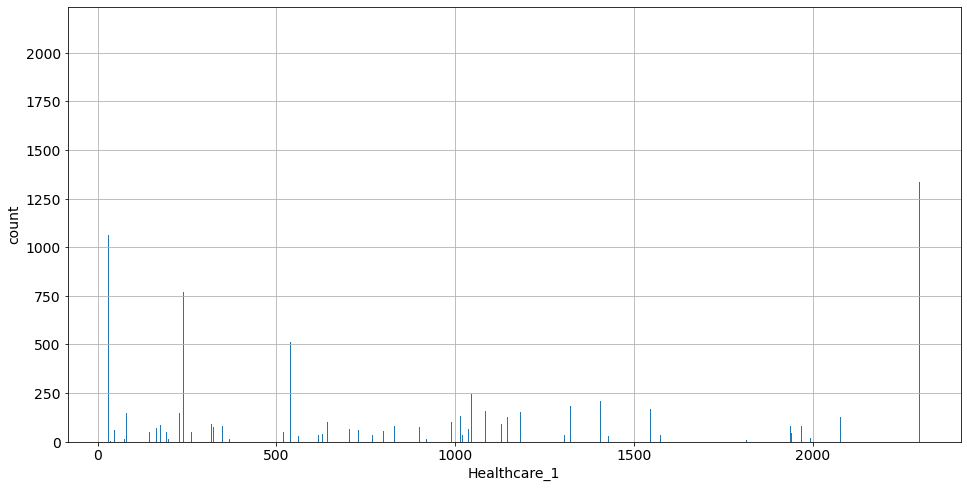

In [56]:
plt.figure(figsize = (16, 8))

train_df['Healthcare_1'].hist(density=False, bins=1000)
plt.ylabel('count')
plt.xlabel('Healthcare_1')
plt.show()

In [57]:
rooms_median = train_df.groupby(['Rooms'])['Square'].agg('median').to_dict()
rooms_median

{1: 40.49979116717184,
 2: 55.90060909159408,
 3: 77.47287307581558,
 4: 98.68900310917077,
 5: 117.8559691942933,
 8: 212.9323610463113}

In [58]:
def q025(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

train_df.groupby(['Rooms'])['Square'].agg([q025, q975, 'max'])

,q025,q975,max
Rooms,,,
1,30.062248,58.692775,58.746662
2,39.536500,80.584916,80.596149
3,52.915093,117.238423,117.244023
4,64.280404,156.995341,159.803906
5,41.368887,222.136500,241.123488
8,212.932361,212.932361,212.932361


In [59]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.square_per_room = None
        self.quantile025_df = None
        self.median_df = None
        self.quantile975_df = None
        self.quantile_df = None
        self.districts_healthcare = None
        self.q_max = None
        self.q_min = None
        
    def fit(self, X):
        
        
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        
        self.square_per_room = 26
        
        def q025(x):
            return x.quantile(0.025)

        def q975(x):
            return x.quantile(0.975)
        
        self.rooms_quantile025 = X.groupby(['Rooms'])['Square'].agg(q025).to_dict()
        self.rooms_quantile975 = X.groupby(['Rooms'])['Square'].agg(q975).to_dict()       
        self.districts_healthcare = X.groupby(['DistrictId'])['Healthcare_1'].agg('median').to_dict()
        
        self.q_max = np.quantile(X['Healthcare_1'], q=0.9)
        self.q_min = np.quantile(X['Healthcare_1'], q=0.1)
        
            
    def transform(self, X):
        """Трансформация данных"""
        
        # Сначала отброшу нижнюю границу Square
        X.loc[X['Square'] < 15, 'Square'] = 15
        
       # Rooms
        X['Rooms_Outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_Outlier'] = 1
        X.loc[X['Rooms_Outlier'] == 1, 'Rooms'] = round(X['Square']/self.square_per_room, 0).astype(np.int8)
      
       # Square
        X['Square_More_Life_Outlier'] = 0
        X.loc[X['Square'] < X['LifeSquare'], 'Square_More_Life_Outlier'] = 1
        X['Square'], X['LifeSquare'] = \
                np.where(X['Square'] < X['LifeSquare'],\
                (X['LifeSquare'], X['Square']), (X['Square'], X['LifeSquare']))
        X.loc[X['Square'] < X['Rooms'].map(self.rooms_quantile025), 'Square'] = X['Rooms'].map(self.rooms_quantile025)
        X.loc[X['Square'] > X['Rooms'].map(self.rooms_quantile975), 'Square'] = X['Rooms'].map(self.rooms_quantile975)       

       # LifeSquare    
        X['LifeSquare_Outlier'] = 0
        condition_min = (X['LifeSquare'] > X['Square'] * 0.7)
        condition_max = (X['LifeSquare'] < X['Square'] * 0.5)

        X.loc[condition_min, 'LifeSquare_Outlier'] = 1
        X.loc[condition_max, 'LifeSquare_Outlier'] = 1

        X.loc[condition_min, 'LifeSquare'] = X['Square'] * 0.5
        X.loc[condition_max, 'LifeSquare'] = X['Square'] * 0.7

        X['LifeSquare_Nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_Nan'] = 1
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X['Square'] * 0.7
    
       # KitchenSquare        
        X['KitchenSquare_outlier'] = 0
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare_outlier'] = 1
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = X['Square'] * 0.1

        X.loc[X['KitchenSquare'] > X['LifeSquare'], 'KitchenSquare_outlier'] = 1
        X.loc[X['KitchenSquare'] > X['LifeSquare'], 'KitchenSquare'] = X['Square'] * 0.1
      
       # HouseFloor, Floor       
        X['Floor_More_HouseFloor_Outlier'] = 0

        X.loc[X['Floor'] > X['HouseFloor'], 'Floor_More_HouseFloor_Outlier'] = 1
        X['Floor'], X['HouseFloor'] = \
                np.where(X['Floor'] > X['HouseFloor'],\
                (X['HouseFloor'], X['Floor']), (X['Floor'], X['HouseFloor']))

        X['Floor_Outlier'] = 0
        X.loc[X['Floor'] == 0, 'Floor_Outlier'] = 1
        X.loc[X['Floor'] == 0, 'Floor'] = 1
    
       # HouseYear       
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020    
        
       # Healthcare_1        
        X['Healthcare_1_Nan'] = 0          
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_Nan'] = 1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare)
        X['Healthcare_1'].fillna(X['Healthcare_1'].median(), inplace=True)       

        X['Healthcare_1'].clip(lower = self.q_min, upper= self.q_max, axis=0, inplace=True)
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

In [60]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df, y = None):
        
        df = df.copy()
        y = y.copy()
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        if y is not None:
            y = pd.DataFrame(y)
            df['Price'] = y.values
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def transform(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=21)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)

        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)       
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
               
        return df

### 5. Разбиение на train и test  <a class='anchor' id='split'>

In [61]:
target_name = 'Price'

In [62]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [64]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [65]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [66]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [67]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 6. Отбор признаков  <a class='anchor' id='feature_selection'>

In [68]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Rooms_Outlier',
 'Square_More_Life_Outlier',
 'LifeSquare_Outlier',
 'LifeSquare_Nan',
 'KitchenSquare_outlier',
 'Floor_More_HouseFloor_Outlier',
 'Floor_Outlier',
 'Healthcare_1_Nan',
 'DistrictYear',
 'DistrictDensity',
 'DistrictPrice',
 'Floor_cat',
 'Social']

In [69]:
feature_names = ['Rooms','Square','LifeSquare','KitchenSquare','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1']

new_feature_names = ['DistrictYear','DistrictDensity','DistrictPrice','Social']

# deleted_feature_names = ['Shops_1', 'KitchenSquare_outlier', 
#                        'Floor_cat', 'Floor_More_HouseFloor_Outlier', 'Floor_Outlier',
#                        'LifeSquare_Nan','Healthcare_1_Nan','Square_More_Life_Outlier',
#                         'Rooms_Outlier']

In [70]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

gb_model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=21, )
%%time params = {'n_estimators':[50, 100, 200, 400], 'max_depth':[3, 5, 7, 10]}
gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=5), random_state=21, shuffle=True), n_jobs=-1) 
gs.fit(X_train, y_train)
gs.best_params_

In [71]:
gb_model = GradientBoostingRegressor(criterion = 'mse',
                                    min_samples_leaf = 80,
                                     random_state=21,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber',
                                     learning_rate=0.1)

%%time
params = {'min_samples_leaf' : [70, 80, 100, 120]               
                         }
gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=5), n_jobs=-1)

%%time
gs.fit(X_train, y_train)

gs.best_params_

In [72]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', loss='huber', max_features='sqrt',
                          min_samples_leaf=80, n_estimators=2250,
                          random_state=21)

**Оценка модели**

Train R2:	0.838
Test R2:	0.745


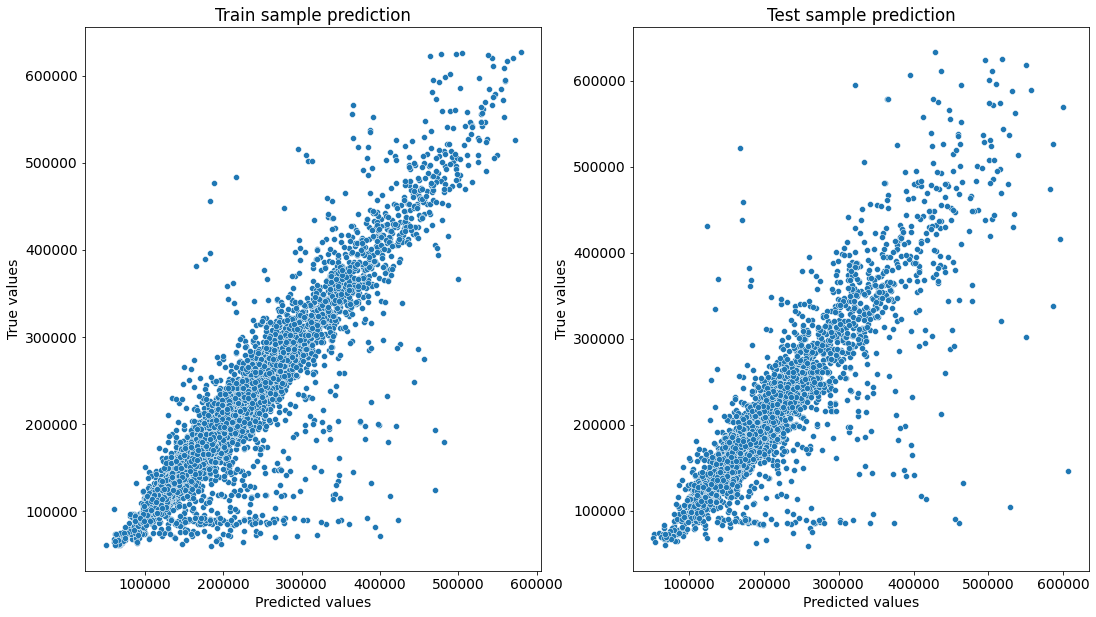

In [73]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

**Кросс-валидация**

In [74]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76020513, 0.7113914 , 0.7520894 ])

In [75]:
cv_score.mean()

0.7412286401221634

**Важность признаков**

In [76]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.250468
13,DistrictPrice,0.211758
0,Rooms,0.137585
7,Social_1,0.081399
3,KitchenSquare,0.057015
2,LifeSquare,0.053879
14,Social,0.044031
8,Social_2,0.034871
5,HouseYear,0.029250
4,HouseFloor,0.026792


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [77]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [78]:
predictions = gb_model.predict(test_df)
predictions

array([176115.08662446, 119777.57087341, 141333.15330257, ...,
       153246.69944935, 192118.09586443, 272659.21229602])

In [79]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,176115.086624
1,5925,119777.570873
2,960,141333.153303
3,3848,86389.541051
4,746,191384.704511


In [80]:
submit.to_csv('rf_submit.csv', index=False)